In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bilstm/16x5_history.json
/kaggle/input/bilstm/16x3_history.json
/kaggle/input/bilstm/32x3_history.json
/kaggle/input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv
/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv
/kaggle/input/models/16x5_model_best.pth
/kaggle/input/models/32x3_model_best.pth
/kaggle/input/models/16x3_model_best.pth


In [2]:
files = ["16x3","32x3","16x5"]
train_losses = []
valid_losses = []
for file in files:
    with open("/kaggle/input/bilstm/"+file+'_history.json') as f:
        d = json.load(f)
    train_losses.append(d["train_loss"][::5])
    valid_losses.append(d["valid_loss"][::5])
train_losses

[[0.060152248817392145,
  0.007101331850351217,
  0.006067821889233791,
  0.005950372832124096,
  0.005898020828059335,
  0.005811259255215008,
  0.005784745661838072,
  0.005678084681289002,
  0.005588285038967054,
  0.005562737475573281,
  0.005527563999880317,
  0.0054534509014193535,
  0.005422454022685784,
  0.005382727844797252,
  0.005331191946935399,
  0.005274257192433296,
  0.005242076322735991,
  0.005176080723350162,
  0.005156100168632653,
  0.005116320464596615,
  0.005071517667253,
  0.005018700051595588,
  0.004979224436138748,
  0.0049390295302066305,
  0.004905356379320345,
  0.004872451996378826,
  0.00484640887615797,
  0.00481616772546976,
  0.004801392477662073,
  0.004803977331012093],
 [0.008733566492664845,
  0.006348419526312671,
  0.0061255391019735305,
  0.005935876082222044,
  0.005841138266887639,
  0.005781295128086653,
  0.005689444126803053,
  0.005595375910904463,
  0.005525479851915438,
  0.005455736310725224,
  0.005397983264200172,
  0.0053339122920

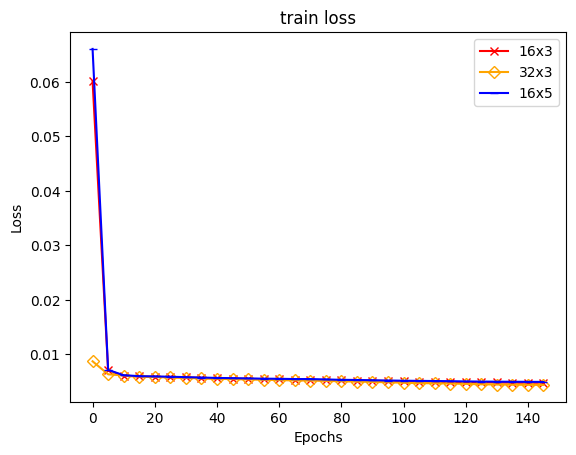

In [3]:
plt.figure()
plot_type = ["x","D","_"]
colors = ["r","orange","b"]
for train_loss, label, pt ,color in zip(train_losses, files, plot_type, colors): 
    
    plt.plot(range(0,len(train_loss*5),5), train_loss,color = color ,marker = pt,markerfacecolor='none',label=label)
    plt.title("train loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
plt.legend()

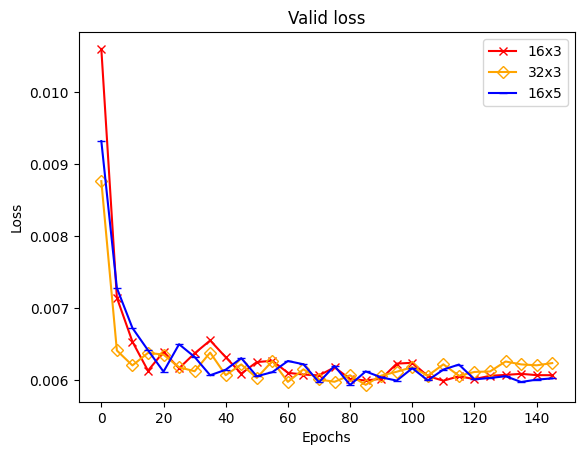

In [4]:
plt.figure()
plot_type = ["x","D","_"]
colors = ["r","orange","b"]
for valid_loss, label, pt ,color in zip(valid_losses, files, plot_type, colors): 
    
    plt.plot(range(0,len(valid_loss*5),5), valid_loss,color = color ,marker = pt,markerfacecolor='none',label=label)
    plt.title("Valid loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
plt.legend()

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
from timm.scheduler import CosineLRScheduler
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import time
from sklearn.metrics import average_precision_score
from timm.scheduler import CosineLRScheduler
plt.style.use("ggplot")
import json
from pyarrow.parquet import ParquetFile
import pyarrow as pa
import ctypes
import gc
import os
import torch.jit as jit
import torch.autograd as autograd
import random 
from torch.autograd import Variable

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_cuda = torch.cuda.is_available()
device

'cpu'

In [7]:
SEED = 1
os.environ["PL_GLOBAL_SEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [8]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [9]:
df_train = pd.read_csv("/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv")
df_train

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [10]:
df_train = df_train.drop(columns = ["date"])

In [11]:
df_test = pd.read_csv("/kaggle/input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv")
df_test

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93
...,...,...,...,...,...,...,...,...
341,-23,-2,1034,NW,231.97,0,0,8
342,-22,-3,1034,NW,237.78,0,0,10
343,-22,-3,1034,NW,242.70,0,0,10
344,-22,-4,1034,NW,246.72,0,0,8


In [12]:
def cleaning(data: pd.DataFrame)->pd.DataFrame:
    print("before cleaning data")
    print(data.isna().sum())
    print("len of data is: ",len(data))
    
    print("after cleaning data")
    data.dropna()
    print(data.isna().sum())
    print("len of data is: ",len(data))
    return data
df_train = cleaning(df_train)

before cleaning data
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64
len of data is:  43800
after cleaning data
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64
len of data is:  43800


In [13]:
df_train = df_train.drop(columns = ["snow"])
df_test = df_test.drop(columns = ["snow"])

In [14]:
#one hot encoding
from sklearn.preprocessing import OneHotEncoder
catogorical_columns = df_train.select_dtypes(include = ['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(df_train[catogorical_columns])
train_encoded = encoder.transform(df_train[catogorical_columns])
test_encoded = encoder.transform(df_test[catogorical_columns])

train_encoded_df = pd.DataFrame(train_encoded, columns = encoder.get_feature_names_out(catogorical_columns))
test_encoded_df = pd.DataFrame(test_encoded, columns = encoder.get_feature_names_out(catogorical_columns))

df_train = pd.concat([df_train, train_encoded_df], axis = 1)
df_test = pd.concat([df_test, test_encoded_df], axis = 1)

df_train = df_train.drop(catogorical_columns, axis = 1)
df_test = df_test.drop(catogorical_columns, axis = 1)

df_test

,dew,temp,press,wnd_spd,rain,pollution,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,-16,4,1027,3.58,0,128,0.0,0.0,1.0,0.0
1,-17,5,1027,7.60,0,77,0.0,0.0,1.0,0.0
2,-16,4,1027,9.39,0,65,0.0,0.0,1.0,0.0
3,-16,1,1028,0.89,0,79,0.0,0.0,0.0,1.0
4,-14,0,1028,1.79,0,93,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
341,-23,-2,1034,231.97,0,8,0.0,1.0,0.0,0.0
342,-22,-3,1034,237.78,0,10,0.0,1.0,0.0,0.0
343,-22,-3,1034,242.70,0,10,0.0,1.0,0.0,0.0
344,-22,-4,1034,246.72,0,8,0.0,1.0,0.0,0.0


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() #defualt is (0,1)

cols = [i for i in range(5)]
columns = df_train.columns[cols].tolist()

df_train[columns] = scaler.fit_transform(df_train[columns])
df_test[columns] = scaler.transform(df_test[columns])

df_train

,pollution,dew,temp,press,wnd_spd,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,0.129779,0.352941,0.245902,0.527273,0.002290,0,0.0,0.0,1.0,0.0
1,0.148893,0.367647,0.245902,0.527273,0.003811,0,0.0,0.0,1.0,0.0
2,0.159960,0.426471,0.229508,0.545455,0.005332,0,0.0,0.0,1.0,0.0
3,0.182093,0.485294,0.229508,0.563636,0.008391,0,0.0,0.0,1.0,0.0
4,0.138833,0.485294,0.229508,0.563636,0.009912,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
43795,0.008048,0.250000,0.278689,0.781818,0.395659,0,0.0,1.0,0.0,0.0
43796,0.010060,0.264706,0.262295,0.781818,0.405588,0,0.0,1.0,0.0,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.413996,0,0.0,1.0,0.0,0.0
43798,0.008048,0.264706,0.245902,0.781818,0.420866,0,0.0,1.0,0.0,0.0


In [16]:
train_size = int(len(df_train) * 0.8)
num_epochs = 150
steps = train_size*num_epochs
warmup_steps = int(steps*0.2)
train= df_train.iloc[:train_size, :]
val = df_train.iloc[train_size:, :]
train

,pollution,dew,temp,press,wnd_spd,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,0.129779,0.352941,0.245902,0.527273,0.002290,0,0.0,0.0,1.0,0.0
1,0.148893,0.367647,0.245902,0.527273,0.003811,0,0.0,0.0,1.0,0.0
2,0.159960,0.426471,0.229508,0.545455,0.005332,0,0.0,0.0,1.0,0.0
3,0.182093,0.485294,0.229508,0.563636,0.008391,0,0.0,0.0,1.0,0.0
4,0.138833,0.485294,0.229508,0.563636,0.009912,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
35035,0.022133,0.308824,0.426230,0.400000,0.195540,0,0.0,1.0,0.0,0.0
35036,0.018109,0.279412,0.426230,0.418182,0.203948,0,0.0,1.0,0.0,0.0
35037,0.023139,0.279412,0.426230,0.418182,0.213877,0,0.0,1.0,0.0,0.0
35038,0.020121,0.279412,0.409836,0.418182,0.222285,0,0.0,1.0,0.0,0.0


In [17]:
window_size = 11#24*7

# TrainSet
X_sequences = []
y_values = []

n_past = 11
n_future = 1

for i in range(n_past, len(train) - n_future+1):
    X_seq = train.iloc[i - n_past:i].drop(columns=["pollution"]).values
    y_val = train.iloc[i + n_future - 1:i + n_future].pollution
    X_sequences.append(X_seq)
    y_values.append(y_val)

X_train = np.array(X_sequences)
y_train = np.array(y_values)

# ValidSet
X_sequences = []
y_values = []

for i in range(n_past, len(val) - n_future+1):
    X_seq = val.iloc[i - n_past:i].drop(columns=["pollution"]).values
    y_val = val.iloc[i + n_future - 1:i + n_future].pollution
    X_sequences.append(X_seq)
    y_values.append(y_val)

X_valid = np.array(X_sequences)
y_valid = np.array(y_values)

# TestSet
X_sequences = []
y_values = []
for i in range(n_past, len(df_test) - n_future+1):
    X_seq = df_test.iloc[ i- n_past:i].drop(columns=["pollution"]).values
    Y_val = df_test.iloc[i + n_future - 1:i + n_future]['pollution']
    X_sequences.append(X_seq)
    y_values.append(Y_val)

X_test = np.array(X_sequences)
y_test = np.array(y_values)

print('train_data'.center(50, '-'))
print(X_train.shape)
print(y_train.shape)
print('test_data'.center(50, '-'))
print(X_test.shape)
print(y_test.shape)

--------------------train_data--------------------
(35029, 11, 9)
(35029, 1)
--------------------test_data---------------------
(335, 11, 9)
(335, 1)


In [18]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_valid = torch.from_numpy(X_valid.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1,1))
y_valid = torch.from_numpy(y_valid.astype(np.float32).reshape(-1,1))
y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1,1))

In [19]:
class BiLSTM(nn.Module):
    def __init__(self, hidden_size,use_cuda,dropout = 0.2, bidir=True):
        
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.use_gpu = use_cuda
        self.lstm = nn.LSTM(input_size=hidden_size,dropout=dropout, hidden_size=hidden_size, bidirectional=bidir)
        self.fc1 = nn.Linear(
            hidden_size * 2, hidden_size*2*2
        )
        self.ln1 = nn.LayerNorm(hidden_size*2*2)
        self.fc2 = nn.Linear(hidden_size * 2*2, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        

#         x = F.normalize(x,dim=0)
          # log probabilities + hidden states

    def init_hidden(self,batch_size):
        # first is the hidden h
        # second is the cell c
        if self.use_gpu:
            return (autograd.Variable(torch.zeros(2, batch_size, self.hidden_size).cuda()),
                    autograd.Variable(torch.zeros(2, batch_size, self.hidden_size).cuda()))
        else:
            return (Variable(torch.zeros(2, batch_size, self.hidden_size)),
                    Variable(torch.zeros(2, batch_size, self.hidden_size)))

    def forward(self, x):
        batch_size = x[0].size(0)
        self.hidden = self.init_hidden(batch_size)
#         x = x.transpose(0,1)
        lstm, self.hidden = self.lstm(x, self.hidden)
        lstm = self.fc1(lstm)
        lstm = self.ln1(lstm)
        lstm = nn.functional.relu(lstm)
        lstm = self.fc2(lstm)
        lstm = self.ln2(lstm)
        lstm = nn.functional.relu(lstm)
#         y = self.fc_out(lstm[:,-1,:])
        
        return lstm

In [20]:
class mutiBiLSTM(nn.Module):
    def __init__(self, input_size,hidden_size, out_size,n_layers,use_cuda,dropout = 0.2, bidir=True):
        
        super(mutiBiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.n_layers = n_layers
        
        self.fc_in = nn.Linear(input_size, hidden_size)
        self.ln = nn.LayerNorm(hidden_size)
        self.mutibilstm = nn.ModuleList(
            [
                BiLSTM(hidden_size,use_cuda = use_cuda,dropout = dropout ,bidir=bidir)
                for _ in range(n_layers)
            ]
        )
        self.fc_out = nn.Linear(hidden_size, out_size)
        
    def forward(self, x ):
        
        x = self.fc_in(x)
        x = self.ln(x)
        x = nn.functional.relu(x)
        for i, lstm in enumerate(self.mutibilstm):
            x = lstm(x)
        x = self.fc_out(x[:, -1, :])
        return x
        

In [21]:
from timm.scheduler import CosineLRScheduler


model_1 = mutiBiLSTM(input_size=9,hidden_size=16,out_size=1,n_layers=3 ,use_cuda=use_cuda,bidir=True ).to(device)
model_2 = mutiBiLSTM(input_size=9,hidden_size=32,out_size=1,n_layers=3 ,use_cuda=use_cuda,bidir=True ).to(device)
model_3 = mutiBiLSTM(input_size=9,hidden_size=16,out_size=1,n_layers=5 ,use_cuda=use_cuda,bidir=True ).to(device)
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3,weight_decay = 0)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3,weight_decay = 0)
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=1e-3,weight_decay = 0)

steps = train_size*num_epochs
scheduler = CosineLRScheduler(optimizer_1,t_initial= steps,warmup_t=warmup_steps, warmup_lr_init=1e-5,lr_min=2e-8,)
scheduler = CosineLRScheduler(optimizer_2,t_initial= steps,warmup_t=warmup_steps, warmup_lr_init=1e-5,lr_min=2e-8,)
scheduler = CosineLRScheduler(optimizer_3,t_initial= steps,warmup_t=warmup_steps, warmup_lr_init=1e-5,lr_min=2e-8,)
# scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.5, last_epoch=-1, verbose=False,)
criterion = nn.MSELoss()



/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [22]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32

train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          )

val_set = TensorDataset(X_valid, y_valid)
val_loader = DataLoader(val_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          )
test_set = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_set,
                          batch_size=1,
                          shuffle=True,
                          drop_last=True,
                          )

In [23]:
model_1.load_state_dict(torch.load(f'/kaggle/input/models/16x3_model_best.pth',map_location=device))
model_2.load_state_dict(torch.load(f'/kaggle/input/models/32x3_model_best.pth',map_location=device))
model_3.load_state_dict(torch.load(f'/kaggle/input/models/16x5_model_best.pth',map_location=device))

<All keys matched successfully>

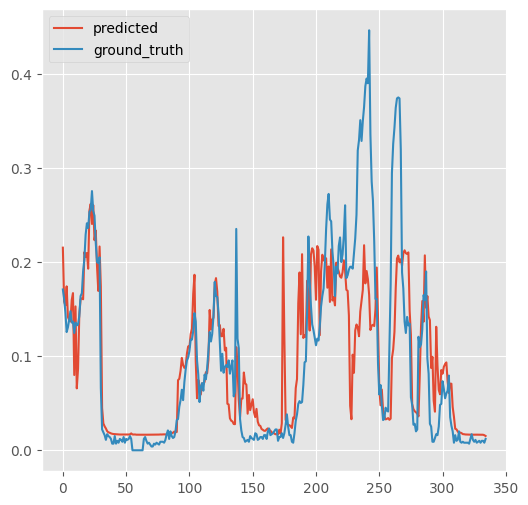

In [32]:
with torch.no_grad():
    # h = None
    predicted = model_1(X_test.to(device))
    # h = [hi.detach() for hi in h]
plt.figure(figsize=(6, 6))
plt.plot(predicted.detach().cpu().numpy(), label='predicted')
plt.plot(y_test, label='ground_truth')
plt.legend()
plt.show()

In [33]:
predict = predicted.detach().cpu().numpy()
rmse = np.sqrt(mean_squared_error(y_test, predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)
print(rmse)
print(mae)
print(r2)

0.063568115
0.038423922
0.5905146014652501


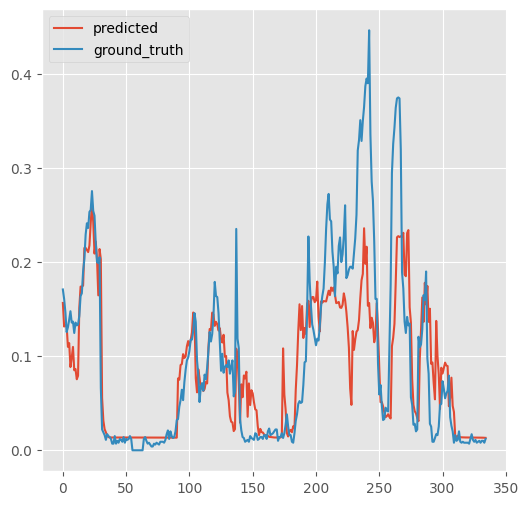

In [38]:
with torch.no_grad():
    # h = None
    predicted = model_2(X_test.to(device))
    # h = [hi.detach() for hi in h]
plt.figure(figsize=(6, 6))
plt.plot(predicted.detach().cpu().numpy(), label='predicted')
plt.plot(y_test, label='ground_truth')
plt.legend()
plt.show()

In [39]:
predict = predicted.detach().cpu().numpy()
rmse = np.sqrt(mean_squared_error(y_test, predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)
print(rmse)
print(mae)
print(r2)

0.060637858
0.037203938
0.6273960559426701


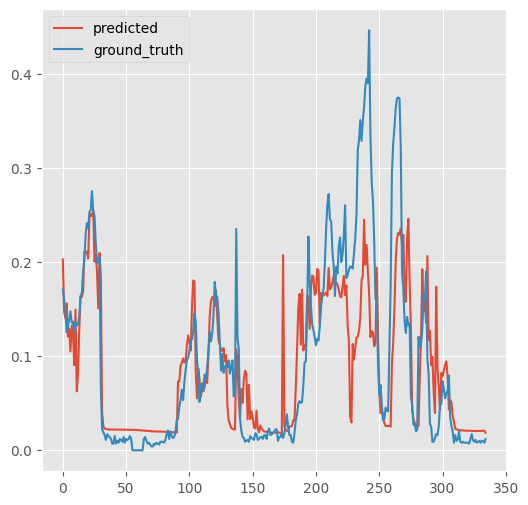

In [36]:
with torch.no_grad():
    # h = None
    predicted = model_3(X_test.to(device))
    # h = [hi.detach() for hi in h]
plt.figure(figsize=(6, 6))
plt.plot(predicted.detach().cpu().numpy(), label='predicted')
plt.plot(y_test, label='ground_truth')
plt.legend()
plt.show()

In [37]:
predict = predicted.detach().cpu().numpy()
rmse = np.sqrt(mean_squared_error(y_test, predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)
print(rmse)
print(mae)
print(r2)

0.062006745
0.03846242
0.6103833356007013
